#### Image Extraction and Process

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Load CSV file
file_path = r"MATWI/labels.xlsx"
df = pd.read_excel(file_path)

# Drop rows where 'type' is NaN or empty
df = df.dropna(subset=['type', 'wear', 'ImageFile'])  # Remove rows where 'type' is NaN
df = df[df['type'].str.strip() != '']  # Remove rows where 'type' is an empty string or whitespace

print(df['type'].value_counts())

label_encoder = LabelEncoder()
df['wear_category_encoded'] = label_encoder.fit_transform(df['type'])

# Display the result
df.head(2)

type
flank_wear             1149
flank_wear+adhesion     335
adhesion                179
Name: count, dtype: int64


,ImageName,SensorName,Set,ImageID,SensorID,wear,type,ImageDateTime,SensorDateTime,ImageFile,SensorFile,wear_category_encoded
0,File_name_2022-09-09T13_42_21.698185.jpg,File_name_2022-09-09T13_30_37.534347.csv,1,0.0,0.0,30.0,flank_wear,2022-09-09 13:42:21.698,2022-09-09 13:30:37.534,MATWI/Set1/images/File_name_2022-09-09T13_42_2...,MATWI/Set1/sensordata/File_name_2022-09-09T13_...,1
1,File_name_2022-09-09T13_57_28.118460.jpg,File_name_2022-09-09T13_42_22.323924.csv,1,1.0,1.0,30.0,flank_wear,2022-09-09 13:57:28.118,2022-09-09 13:42:22.324,MATWI/Set1/images/File_name_2022-09-09T13_57_2...,MATWI/Set1/sensordata/File_name_2022-09-09T13_...,1


In [3]:
df["Images"] = df["ImageFile"].apply(lambda x: cv2.resize(cv2.imread(x), (224, 224)))  # Load and resize images

In [4]:
# Perform stratified train-test split
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['wear_category_encoded']
)

print(train_df['type'].value_counts())
print(test_df['type'].value_counts())

val_df, tst_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['wear_category_encoded'])

print(val_df['type'].value_counts())
print(tst_df['type'].value_counts())

type
flank_wear             919
flank_wear+adhesion    268
adhesion               143
Name: count, dtype: int64
type
flank_wear             230
flank_wear+adhesion     67
adhesion                36
Name: count, dtype: int64
type
flank_wear             115
flank_wear+adhesion     33
adhesion                18
Name: count, dtype: int64
type
flank_wear             115
flank_wear+adhesion     34
adhesion                18
Name: count, dtype: int64


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define an augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,          # Rotate images randomly by 20 degrees# Randomly shift images horizontally by 20%# Randomly shift images vertically by 20%
    shear_range=0.2,            # Shear transformation             # Random zoom
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill missing pixels with the nearest pixel
)

# Augment images for underrepresented classes
def augment_images(images, num_augmented):
    augmented_images = []
    for img in images:
        img = img.reshape((1,) + img.shape)  # Reshape for ImageDataGenerator
        i = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            i += 1
            if i >= num_augmented:
                break
    return np.array(augmented_images)

# Filter dataset for the underrepresented class (e.g., 'adhesion')
adhesion_images = train_df[train_df['type'] == 'adhesion']['Images'].tolist()
adhesion_augmented = augment_images(np.array(adhesion_images), num_augmented=5)  # Create 100 augmented samples

# Repeat for other underrepresented classes
built_up_images = train_df[train_df['type'] == 'flank_wear+adhesion']['Images'].tolist()
built_up_augmented = augment_images(np.array(built_up_images), num_augmented=3)

# Convert augmented images back to DataFrame format
augmented_data = pd.DataFrame({
    'Images': list(adhesion_augmented) + list(built_up_augmented),
    'type': ['adhesion'] * len(adhesion_augmented) + ['flank_wear+adhesion'] * len(built_up_augmented),
    'wear_category_encoded': label_encoder.transform(['adhesion'] * len(adhesion_augmented) + ['flank_wear+adhesion'] * len(built_up_augmented)),
})

# Append to the original DataFrame
train_df = pd.concat([train_df, augmented_data], ignore_index=True)


# Prepare images and labels from the DataFrame
X_train = np.array(train_df['Images'].tolist()) / 255.0  # Normalize training images
y_train = np.array(train_df['wear_category_encoded'])
print(y_train)

# For validation data
X_val = np.array(val_df['Images'].tolist()) / 255.0  # Normalize validation images
y_val = np.array(val_df['wear_category_encoded'])

from tensorflow.keras.utils import to_categorical
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=3)  # 3 classes
y_val = to_categorical(y_val, num_classes=3)


[0 1 1 ... 2 2 2]


In [6]:
print(len(y_train))

2849


In [7]:
element_1 = 0
element_2 = 0
element_3 = 0
for element in y_train:
    if element[0] == 1:
        element_1 += 1
    elif element[1] == 1:
        element_2 += 1
    elif element[2] == 1:
        element_3 += 1

print(element_1)
print(element_2)
print(element_3)

858
919
1072


In [8]:
print(train_df.tail(5))

     ImageName SensorName  Set  ImageID  SensorID  wear                 type  \
2844       NaN        NaN  NaN      NaN       NaN   NaN  flank_wear+adhesion   
2845       NaN        NaN  NaN      NaN       NaN   NaN  flank_wear+adhesion   
2846       NaN        NaN  NaN      NaN       NaN   NaN  flank_wear+adhesion   
2847       NaN        NaN  NaN      NaN       NaN   NaN  flank_wear+adhesion   
2848       NaN        NaN  NaN      NaN       NaN   NaN  flank_wear+adhesion   

     ImageDateTime SensorDateTime ImageFile SensorFile  wear_category_encoded  \
2844           NaT            NaT       NaN        NaN                      2   
2845           NaT            NaT       NaN        NaN                      2   
2846           NaT            NaT       NaN        NaN                      2   
2847           NaT            NaT       NaN        NaN                      2   
2848           NaT            NaT       NaN        NaN                      2   

                                

In [9]:
# Save the data

"""
training_data.to_csv("training_data.csv", index=False)
validation_data.to_csv("validation_data.csv", index=False)
testing_data.to_csv("testing_data.csv", index=False)
"""

'\ntraining_data.to_csv("training_data.csv", index=False)\nvalidation_data.to_csv("validation_data.csv", index=False)\ntesting_data.to_csv("testing_data.csv", index=False)\n'

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Load ResNet50 pre-trained on ImageNet
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a feature extractor model
feature_extractor = Model(inputs=resnet.input, outputs=resnet.output)


# Extract features from ResNet for training data
train_features = feature_extractor.predict(X_train, verbose=1)

val_features = feature_extractor.predict(X_val, verbose=1)

# Flatten the feature maps
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 66s 726ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 575ms/step


In [11]:
print(X_train.shape)

(2849, 224, 224, 3)


In [12]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Add convolutional layers with ReLU activation and max pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))  # Input shape: (height, width, channels)
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model.add(layers.Flatten())

# Add fully connected (dense) layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# Output layer with softmax activation (for multi-class classification)
model.add(layers.Dense(3, activation='softmax'))  # Assuming 2 classes for each label (flank_wear, adhesion)

# Summary of the model
model.summary()


/opt/anaconda3/envs/cs512/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,411 (42.64 MB)

 Trainable params: 11,177,411 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
              metrics=['accuracy'])


In [14]:
# Train the model
history = model.fit(
    X_train, y_train,              # Training data
    epochs=3,                    # Number of epochs, adjust based on your need
    batch_size=32,                # Batch size, adjust based on memory and data
    validation_data=(X_val, y_val), # Validation data
    verbose=1                     # To show progress during training
)


Epoch 1/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 399ms/step - accuracy: 0.5884 - loss: 0.8504 - val_accuracy: 0.8494 - val_loss: 0.4248
Epoch 2/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 392ms/step - accuracy: 0.9065 - loss: 0.2683 - val_accuracy: 0.8434 - val_loss: 0.4383
Epoch 3/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 389ms/step - accuracy: 0.9295 - loss: 0.2060 - val_accuracy: 0.8675 - val_loss: 0.3853


In [15]:
X_test = np.array(tst_df['Images'].tolist()) / 255.0  # Normalize testing images
y_test = np.array(tst_df['wear_category_encoded'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step 
Test Accuracy: 0.88

Classification Report:
                     precision    recall  f1-score   support

           adhesion       1.00      0.17      0.29        18
         flank_wear       0.88      0.96      0.92       115
flank_wear+adhesion       0.87      1.00      0.93        34

           accuracy                           0.88       167
          macro avg       0.92      0.71      0.71       167
       weighted avg       0.89      0.88      0.85       167



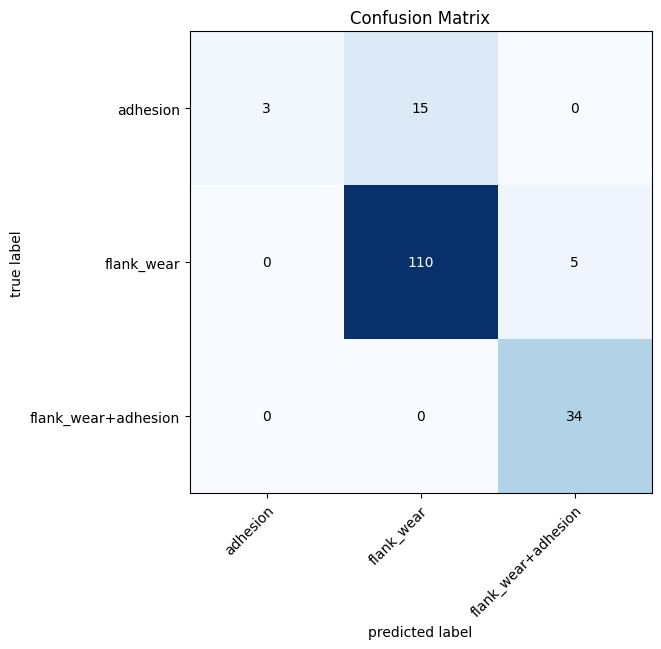

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Predict class probabilities on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_prob, axis=1)

# Ground truth (ensure y_test is in integer form)
#y_test = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), class_names=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step 
Test Accuracy: 0.88

Classification Report:
                     precision    recall  f1-score   support

           adhesion       1.00      0.17      0.29        18
         flank_wear       0.88      0.96      0.92       115
flank_wear+adhesion       0.87      1.00      0.93        34

           accuracy                           0.88       167
          macro avg       0.92      0.71      0.71       167
       weighted avg       0.89      0.88      0.85       167



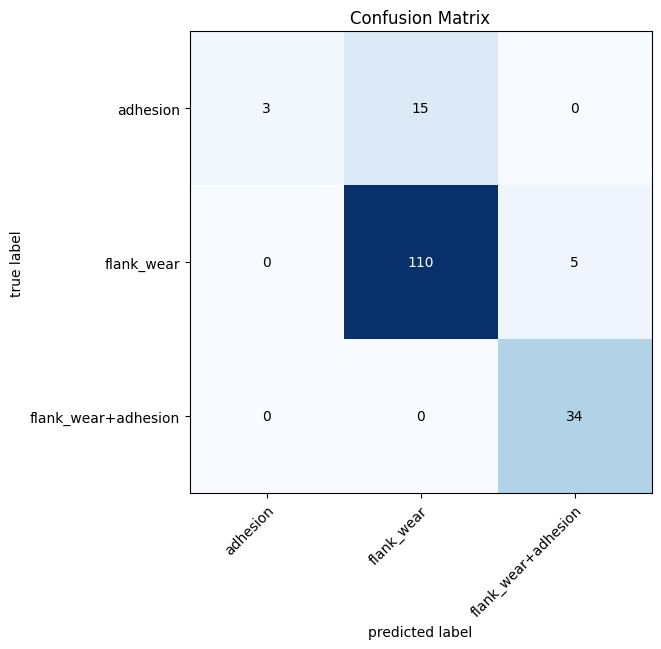

In [18]:
X_test = np.array(tst_df['Images'].tolist()) / 255.0  # Normalize testing images
y_test = np.array(tst_df['wear_category_encoded'])
y_test = to_categorical(y_test, num_classes=3)  # One-hot encode the labels

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Predict class probabilities on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_prob, axis=1)

# Ground truth (ensure y_test is in integer form)
y_test = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), class_names=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.show()